In [1]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from unet.unet import create_unet
from unet.train import train

In [2]:
TRAIN_FOLDER = '../data/train_v2/'
TRAIN_MASK = '../data/train_ship_segmentations_v2.csv'
TEST_FOLDER = '../data/test_v2/'

IMAGE_WIDTH = 768
IMAGE_HEIGHT = 768
IMAGE_CHANNELS = 3

END_IMAGE_SIZE = (256, 256, 3)

In [3]:
full_segmentation = pd.read_csv(TRAIN_MASK)
full_segmentation['EncodedPixels'] = full_segmentation['EncodedPixels'].fillna('')
full_segmentation

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,
231719,ffff2aa57.jpg,
231720,ffff6e525.jpg,
231721,ffffc50b4.jpg,


In [4]:
full_segmentation = full_segmentation.groupby('ImageId')['EncodedPixels'].agg(' '.join).reset_index()
full_segmentation

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,0001b1832.jpg,
...,...,...
192551,fffedbb6b.jpg,
192552,ffff2aa57.jpg,
192553,ffff6e525.jpg,
192554,ffffc50b4.jpg,


In [5]:
def segmentation_mask(encoded_pixels: str):
    mask = np.zeros((IMAGE_WIDTH * IMAGE_HEIGHT))  

    encoded_pixels = encoded_pixels.split()
    start_pixels = np.array([(int(x) - 1) for x in encoded_pixels[::2]]) 
    lengths = np.array([int(x) for x in encoded_pixels[1::2]])
    end_pixels = start_pixels + lengths
    
    for i in range(start_pixels.shape[0]):
        mask[start_pixels[i]:end_pixels[i]] = 1
    mask = mask.reshape(IMAGE_WIDTH, IMAGE_HEIGHT).T
    return mask


def get_encoded_pixels_by_img_id(img_id, dataset):    
    encoded_pixels = dataset[dataset['ImageId'] == img_id]['EncodedPixels']
    if pd.isna(encoded_pixels.values):
        encoded_pixels = ' '
    encoded_pixels = ' '.join(encoded_pixels)
    
    return encoded_pixels


def display_image_with_segmentation(img_id, dataset):
    encoded_pixels = get_encoded_pixels_by_img_id(img_id, dataset)
    segmenation = segmentation_mask(encoded_pixels)

    img = np.asarray(Image.open(os.path.join(TRAIN_FOLDER, img_id)))
    fig, axes = plt.subplots(1, 2, figsize=(15, 15))

    axes[0].imshow(img)
    axes[0].set_title("Image")

    axes[1].imshow(segmenation)
    axes[1].set_title("Segmentation")

    plt.show()

In [6]:
def split_ids(df, number, with_ships=0.75, train_size=0.8):
    with_ships_num_train = int(number * with_ships * train_size)
    with_ships_df = list(df[df['EncodedPixels'] != '']['ImageId'].values)
    with_ships_df = random.sample(with_ships_df, with_ships_num_train)
    
    without_ships_num_train = int(number * train_size - with_ships_num_train)
    without_ships_df  = list(df[df['EncodedPixels'] == '']['ImageId'].values)
    without_ships_df  = random.sample(without_ships_df, without_ships_num_train)
    
    train = np.concatenate((with_ships_df, without_ships_df))
    np.random.shuffle(train)
    
    with_ships_num_test = int((number - len(train)) * with_ships)
    with_ships_df = list(df[(df['EncodedPixels'] != '') & (~df['ImageId'].isin(train))]['ImageId'].values)
    with_ships_df = random.sample(with_ships_df, with_ships_num_test)
    
    without_ships_num_test = number - len(train) - with_ships_num_test
    without_ships_df = list(df[(df['EncodedPixels'] == '') & (~df['ImageId'].isin(train))]['ImageId'].values)
    without_ships_df = random.sample(without_ships_df, without_ships_num_test)
    
    test = np.concatenate((with_ships_df, without_ships_df))
    np.random.shuffle(test)
    
    return train, test

train_ids, test_ids = split_ids(full_segmentation, 5000, with_ships=0.95, train_size=0.9)

In [7]:
X_train = np.zeros((len(train_ids), END_IMAGE_SIZE[0], END_IMAGE_SIZE[1], IMAGE_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), END_IMAGE_SIZE[0], END_IMAGE_SIZE[1], 1), dtype=np.float32)

for n, img_id in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = np.asarray(Image.open(os.path.join(TRAIN_FOLDER, img_id))
                     .resize((END_IMAGE_SIZE[0], END_IMAGE_SIZE[1])), 
                     dtype=np.float32).reshape(END_IMAGE_SIZE)
    X_train[n] = img / 255.0
    
    encoded_pixels = get_encoded_pixels_by_img_id(img_id, full_segmentation)
    
    segmenation = segmentation_mask(encoded_pixels)
    segmenation = np.asarray(Image.fromarray(segmenation)
                             .resize((END_IMAGE_SIZE[0], END_IMAGE_SIZE[1])),
                             dtype=np.float32).reshape((256, 256, 1))
    Y_train[n] = segmenation

100%|██████████████████████████████████████████████████████████████████████████████| 4500/4500 [02:49<00:00, 26.56it/s]


In [8]:
model = create_unet(filters=8)

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['dropout[0][0]']             

 conv2d_15 (Conv2D)             (None, 128, 128, 16  2320        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 8)  520        ['conv2d_15[0][0]']              
 spose)                                                                                           
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 16  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 8)  1160        ['concatenate_3[0][0]']          
          

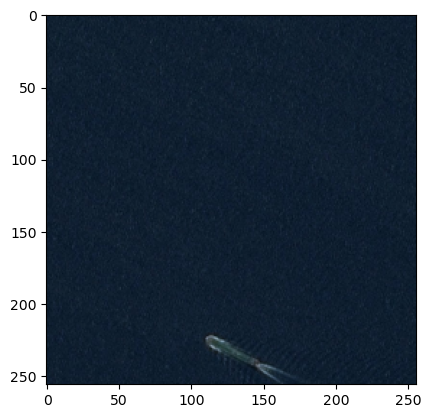

In [9]:
plt.imshow(X_train[5])

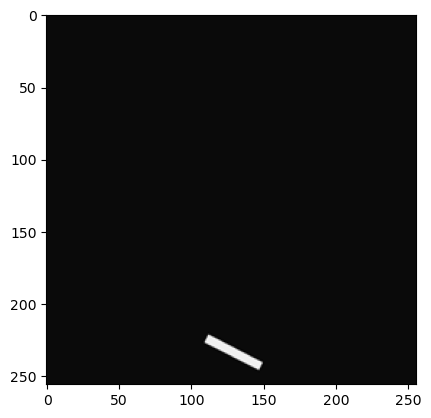

In [10]:
plt.imshow(Y_train[5], cmap='gray')

In [13]:
history = train(model, X_train, Y_train, epochs=25)

Epoch 1/25
225/225 [==============================] - ETA: 0s - loss: -0.3294 - dice_coef: 0.3294
Epoch 1: val_loss improved from inf to -0.47246, saving model to models\unet-segmentation2023-06-25_09-13-48.h5
225/225 [==============================] - 309s 1s/step - loss: -0.3294 - dice_coef: 0.3294 - val_loss: -0.4725 - val_dice_coef: 0.4749
Epoch 2/25
225/225 [==============================] - ETA: 0s - loss: -0.4816 - dice_coef: 0.4816
Epoch 2: val_loss improved from -0.47246 to -0.54463, saving model to models\unet-segmentation2023-06-25_09-13-48.h5
225/225 [==============================] - 304s 1s/step - loss: -0.4816 - dice_coef: 0.4816 - val_loss: -0.5446 - val_dice_coef: 0.5472
Epoch 3/25
225/225 [==============================] - ETA: 0s - loss: -0.5273 - dice_coef: 0.5273
Epoch 3: val_loss did not improve from -0.54463
225/225 [==============================] - 302s 1s/step - loss: -0.5273 - dice_coef: 0.5273 - val_loss: -0.5367 - val_dice_coef: 0.5396
Epoch 4/25
225/225 [=

In [14]:
X_test = np.zeros((len(test_ids), END_IMAGE_SIZE[0], END_IMAGE_SIZE[1], IMAGE_CHANNELS), dtype=np.float32)
Y_test = np.zeros((len(test_ids), END_IMAGE_SIZE[0], END_IMAGE_SIZE[1], 1), dtype=np.float32)

for n, img_id in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = np.asarray(Image.open(os.path.join(TRAIN_FOLDER, img_id))
                     .resize((END_IMAGE_SIZE[0], END_IMAGE_SIZE[1])), 
                     dtype=np.float32).reshape(END_IMAGE_SIZE)
    X_test[n] = img / 255.0

    encoded_pixels = get_encoded_pixels_by_img_id(img_id, full_segmentation)
    
    segmenation = segmentation_mask(encoded_pixels)
    segmenation = np.asarray(Image.fromarray(segmenation)
                             .resize((END_IMAGE_SIZE[0], END_IMAGE_SIZE[1])),
                             dtype=np.float32).reshape((256, 256, 1))
    Y_test[n] = segmenation

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.58it/s]


In [25]:
from tensorflow import keras
import numpy as np
from unet.metrics import dice_coef, dice_loss

models_path = 'models/unet-segmentation2023-06-25_09-13-48.h5'

def predict_model(model, test_ds):
    threshold = 0.5
    
    model = keras.models.load_model(model, custom_objects={'dice_loss': dice_loss, 
                                                                'dice_coef': dice_coef})
    predictions = model.predict(test_ds)
    predictions = np.where(predictions > threshold, 1, 0)
    return predictions

pred = predict_model(models_path, X_test)

16/16 [==============================] - 7s 437ms/step


In [29]:
print(dice_coef(Y_test, pred))

tf.Tensor(0.6892021, shape=(), dtype=float32)


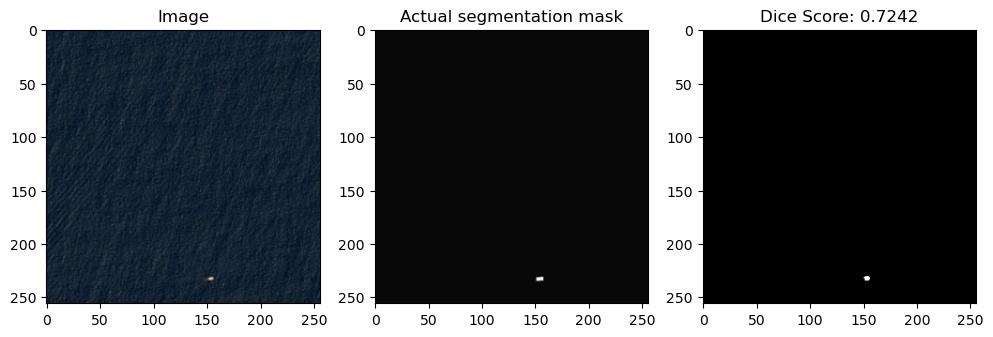

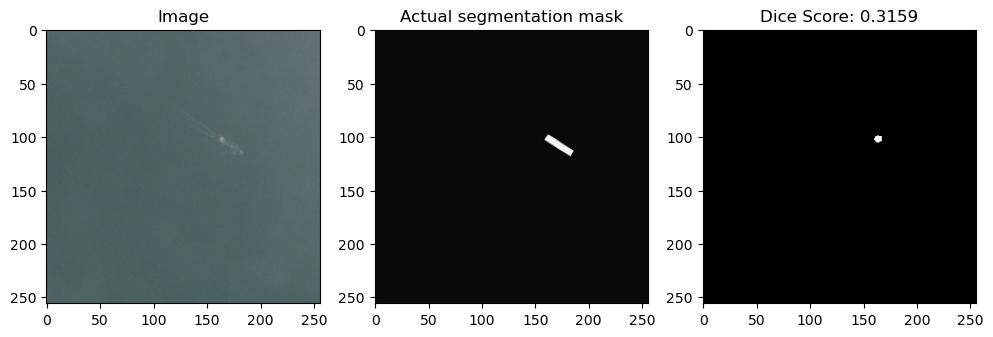

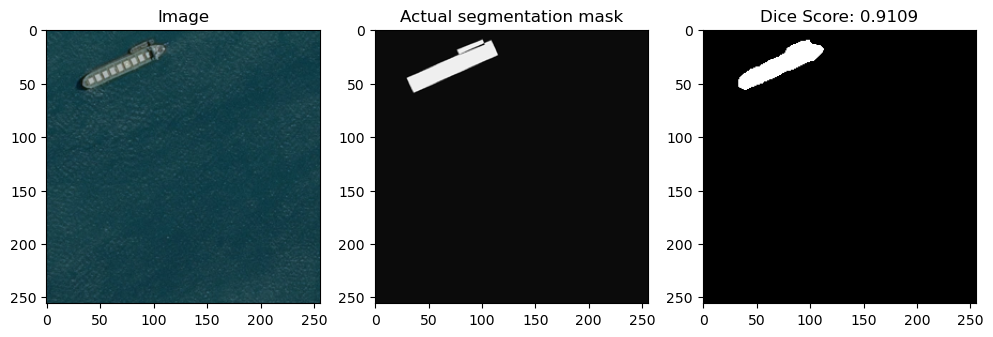

In [27]:
indexes = np.random.choice([_ for _ in range(len(pred))], size=3, replace=False)

for ind in indexes:
    fig, axes = plt.subplots(1, 3)
    fig.set_figheight(16)
    fig.set_figwidth(12)
    
    axes[0].imshow(X_test[ind])
    axes[0].set_title("Image")

    axes[1].imshow(Y_test[ind], cmap='gray')
    
    axes[1].set_title("Actual segmentation mask")

    axes[2].imshow(pred[ind], cmap='gray')
    dice_score = dice_coef(Y_test[ind], pred[ind])
    axes[2].set_title(f"Dice Score: {dice_score:.4f}")
    
plt.show()

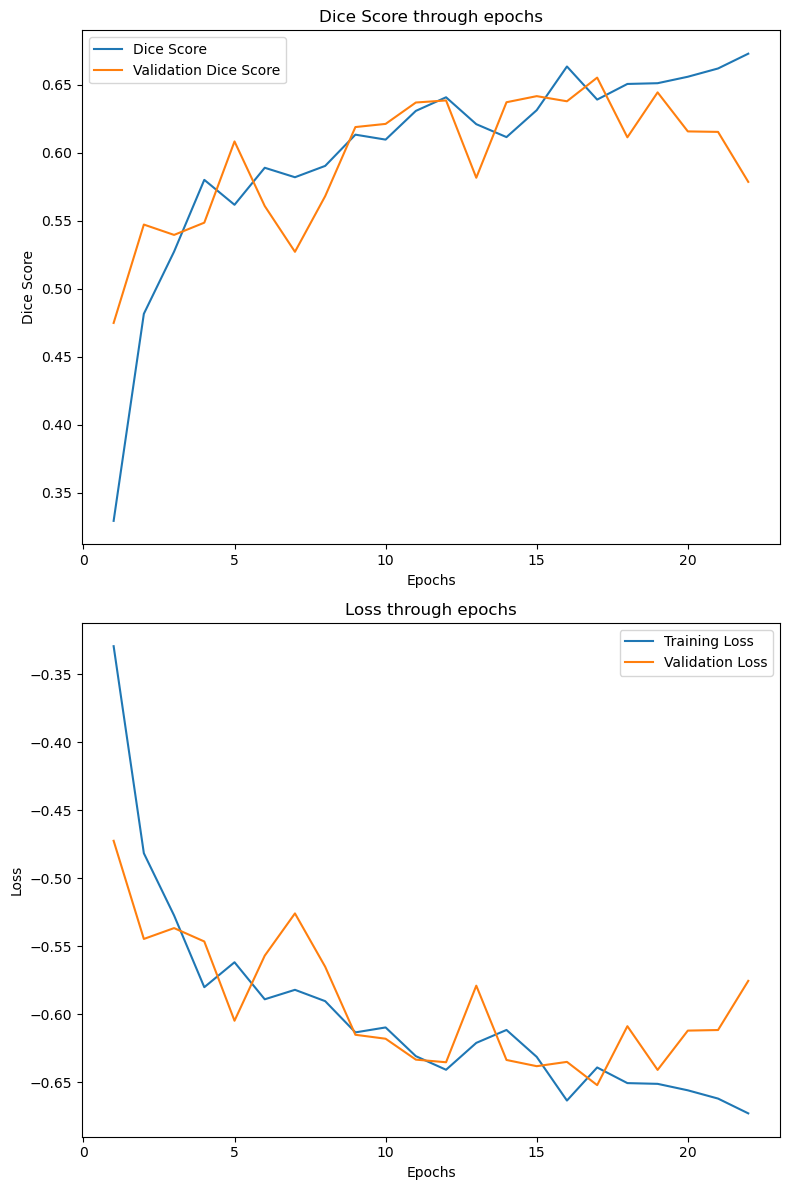

In [23]:
import matplotlib.pyplot as plt


dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# Plot dice score
ax1.plot(range(1, len(dice_coef) + 1), dice_coef, label='Dice Score')
ax1.plot(range(1, len(val_dice_coef) + 1), val_dice_coef, label='Validation Dice Score')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Dice Score')
ax1.set_title('Dice Score through epochs')
ax1.legend()

# Plot validation loss
ax2.plot(range(1, len(loss) + 1), loss, label='Training Loss')
ax2.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss through epochs')
ax2.legend()


plt.tight_layout()
plt.show()